In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


device = "cpu"

Создание датафрейма

In [2]:
df = pd.read_csv('dataset.csv')
df.columns = ['Date', 'Day Temperature', 'Day Pressure', 'Day Wind', 'Night Temperature', 'Night Pressure', 'Night Wind']  
df = df.drop(columns = ['Day Pressure', 'Day Wind', 'Night Temperature', 'Night Pressure', 'Night Wind'])
nan_value = float("NaN")                            
df.replace(" ", nan_value, inplace=True)
df = df.dropna()
df[['Day Temperature']] = df[['Day Temperature']].astype(int)  
print(df)

            Date  Day Temperature
0     2008-01-11              -20
1     2008-01-12              -20
2     2008-01-13               -9
3     2008-01-14               -6
4     2008-01-15               -1
...          ...              ...
5787  2023-12-03               -6
5788  2023-12-04                0
5789  2023-12-05               -7
5790  2023-12-06               -9
5791  2023-12-07              -10

[5783 rows x 2 columns]


Создание графика

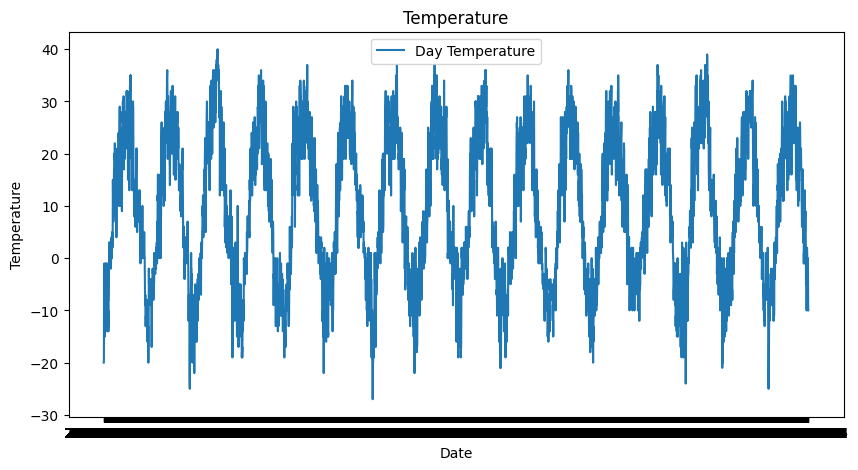

In [3]:
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Day Temperature'], label='Day Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature')
plt.legend()
plt.show()

Графики изменения температуры

In [4]:
import plotly.graph_objs as go
from plotly.offline import iplot

def get_graph(df: pd.DataFrame, title: str) -> None:
    """
    """
    data = []
    
    value = go.Scatter(
        x=df.index,
        y=df.Temperature,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Temperature", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)
    get_graph(df, "Temperature change")

TimeLags генерация 

In [5]:
def get_time_lags(df: pd.DataFrame, n_lags: int) -> pd.DataFrame:
    """


    """
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["Day Temperature"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n


input_dim = 100

df_timelags = get_time_lags(df, input_dim)
print(df_timelags)

            Date  Day Temperature  lag1  lag2  lag3  lag4  lag5  lag6  lag7  \
100   2008-04-20               15  12.0  12.0  11.0   8.0   8.0   9.0  20.0   
101   2008-04-21               19  15.0  12.0  12.0  11.0   8.0   8.0   9.0   
102   2008-04-22               18  19.0  15.0  12.0  12.0  11.0   8.0   8.0   
103   2008-04-23                9  18.0  19.0  15.0  12.0  12.0  11.0   8.0   
104   2008-04-24                4   9.0  18.0  19.0  15.0  12.0  12.0  11.0   
...          ...              ...   ...   ...   ...   ...   ...   ...   ...   
5787  2023-12-03               -6  -1.0  -1.0  -4.0  -1.0   1.0   2.0   2.0   
5788  2023-12-04                0  -6.0  -1.0  -1.0  -4.0  -1.0   1.0   2.0   
5789  2023-12-05               -7   0.0  -6.0  -1.0  -1.0  -4.0  -1.0   1.0   
5790  2023-12-06               -9  -7.0   0.0  -6.0  -1.0  -1.0  -4.0  -1.0   
5791  2023-12-07              -10  -9.0  -7.0   0.0  -6.0  -1.0  -1.0  -4.0   

      lag8  ...  lag91  lag92  lag93  lag94  lag95 

C:\Users\afrodetka\AppData\Local\Temp\ipykernel_15436\206426980.py:8: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\afrodetka\AppData\Local\Temp\ipykernel_15436\206426980.py:8: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [6]:
import sklearn
from sklearn.model_selection import train_test_split

def feature_label_split(df: pd.DataFrame, target_col: str) -> tuple[pd.DataFrame]:
    """

    """
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y


def train_val_test_split(df: pd.DataFrame, target_col: str, test_ratio: float) -> tuple[pd.DataFrame]:
    """

    """
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test


X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    df_timelags, 'Day Temperature', 0.2)

print(f'Процент обучащей выборки: {X_train["lag1"].count() / df_timelags["lag1"].count()*100}%')
print(f'Процент тестовой выборки: {X_test["lag1"].count() / df_timelags["lag1"].count()*100}%')
print(f'Процент валидационной выборки: {X_val["lag1"].count() / df_timelags["lag1"].count()*100}%')

Процент обучащей выборки: 59.985922928030966%
Процент тестовой выборки: 20.007038535984513%
Процент валидационной выборки: 20.007038535984513%


In [18]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()


In [26]:
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train_numeric = X_train[numeric_cols]
X_val_numeric = X_val[numeric_cols]
X_test_numeric = X_test[numeric_cols]


scaler = MinMaxScaler()
X_train_arr = scaler.fit_transform(X_train_numeric)
X_val_arr = scaler.transform(X_val_numeric)
X_test_arr = scaler.transform(X_test_numeric)
y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

In [28]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_features = torch.Tensor(X_train_arr)  #Преобразование массивов NumPy в tensor torch 
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [31]:
class RNNModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, layer_dim: int, output_dim: int, dropout_prob: float) -> None:
        """The __init__ method that initiates an RNN instance.

        Args:
            input_dim (int): The number of nodes in the input layer
            hidden_dim (int): The number of nodes in each layer
            layer_dim (int): The number of layers in the network
            output_dim (int): The number of nodes in the output layer
            dropout_prob (float): The probability of nodes being dropped out

        """
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [43]:
class Optimization:
    """Optimization is a helper class that allows training, validation, prediction.

    Optimization is a helper class that takes model, loss function, optimizer function
    learning scheduler (optional), early stopping (optional) as inputs. In return, it
    provides a framework to train and validate the models, and to predict future values
    based on the models.

    Attributes:
        model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
        loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
        optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        train_losses (list[float]): The loss values from the training
        val_losses (list[float]): The loss values from the validation
        last_epoch (int): The number of epochs that the models is trained
    """
    def __init__(self, model, loss_fn, optimizer) -> None:
        """
        Args:
            model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
            loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
            optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        """
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def train_step(self, x: torch.Tensor, y: torch.Tensor):
        """The method train_step completes one step of training.

        Given the features (x) and the target values (y) tensors, the method completes
        one step of the training. First, it activates the train mode to enable back prop.
        After generating predicted values (yhat) by doing forward propagation, it calculates
        the losses by using the loss function. Then, it computes the gradients by doing
        back propagation and updates the weights by calling step() function.

        Args:
            x (torch.Tensor): Tensor for features to train one step
            y (torch.Tensor): Tensor for target values to calculate losses

        """
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1) -> None:
        """The method train performs the model training

        The method takes DataLoaders for training and validation datasets, batch size for
        mini-batch training, number of epochs to train, and number of features as inputs.
        Then, it carries out the training by iteratively calling the method train_step for
        n_epochs times. If early stopping is enabled, then it  checks the stopping condition
        to decide whether the training needs to halt before n_epochs steps. Finally, it saves
        the model in a designated file path.
        """
        model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader: torch.utils.data.DataLoader, batch_size: int, n_features: int) -> list:
        """The method evaluate performs the model evaluation

        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future."""

        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())
        return predictions, values

    def plot_losses(self) -> None:
        """The method plots the calculated loss values for training and validation"""
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()
     

In [44]:
import torch.optim as optim

input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = RNNModel(** model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

RuntimeError: shape '[64, -1, 101]' is invalid for input of size 6400